# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3Av2:oracle.run1.framed -> cores+wisig",
    "device": "cuda",
    "lr": 0.0001,
    "x_shape": [2, 200],
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 16000, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "C_",
        },
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "W_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag", "take_200", "resample_20Msps_to_25Msps"],
            "episode_transforms": [],
            "domain_prefix": "O_",
        },
    ],
    "seed": 1337,
    "dataset_seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'O_50', 'O_8', 'O_44', 'O_32', 'O_26', 'O_20', 'O_38', 'O_14'}


{'W_4', 'W_3', 'C_4', 'C_2', 'C_3', 'C_5', 'W_2', 'W_1', 'C_1'}


tensor([[[-0.0971,  1.1311,  0.6428,  ...,  0.6900,  0.5495,  0.7515],
         [-0.6699, -0.6023,  0.7298,  ..., -0.1188,  1.1722,  0.1223]],

        [[-0.4650,  0.4729,  0.8381,  ...,  1.1898,  0.5315,  0.0195],
         [-1.1721, -0.8223,  0.9095,  ..., -0.4716, -0.6551, -1.4318]],

        [[ 0.6704, -0.0551, -0.9197,  ..., -0.8651, -0.9602, -0.1043],
         [ 0.8524,  1.1014, -0.5470,  ...,  0.4879,  0.2662,  1.2135]],

        ...,

        [[ 1.0094,  0.2418, -1.2327,  ..., -0.7204, -0.1579,  0.9442],
         [ 0.5694,  0.9394, -0.0507,  ...,  1.0085,  0.7567,  1.0278]],

        [[ 0.0259, -1.0459, -0.2935,  ..., -0.8818, -0.8675, -0.9829],
         [ 0.8104,  0.8015, -0.7676,  ..., -0.1278, -0.7103,  0.6759]],

        [[ 0.4981,  0.4795, -0.3590,  ...,  0.5028, -1.2225, -0.6749],
         [-0.4260,  0.9681,  0.7596,  ...,  0.6907,  0.2936,  0.4766]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 200)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 46.3796, train_label_loss: 2.9812, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3726.8474, train_label_loss: 1.1892, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3733.6622, train_label_loss: 0.7928, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3760.2393, train_label_loss: 0.7082, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3726.2828, train_label_loss: 1.1419, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3718.4233, train_label_loss: 0.9640, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3719.3470, train_label_loss: 1.1968, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3714.9275, train_label_loss: 0.6542, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3694.5021, train_label_loss: 0.8519, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3716.9100, train_label_loss: 0.6168, 


epoch: 1, source_val_acc_label: 0.5545, target_val_acc_label: 0.4705, source_val_label_loss: 48.3408, target_val_label_loss: 1975.7240, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.4115, train_label_loss: 49.4733, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3687.8563, train_label_loss: 0.7143, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3702.9756, train_label_loss: 0.6015, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3712.8554, train_label_loss: 1.1883, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3731.4850, train_label_loss: 0.9719, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3757.0734, train_label_loss: 0.6031, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3745.3478, train_label_loss: 0.5761, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3735.3396, train_label_loss: 0.9056, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3740.6736, train_label_loss: 1.0630, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3744.1877, train_label_loss: 0.5537, 


epoch: 2, source_val_acc_label: 0.7488, target_val_acc_label: 0.5164, source_val_label_loss: 0.6938, target_val_label_loss: 253.6465, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.3802, train_label_loss: 0.8828, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3719.4428, train_label_loss: 0.3471, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3731.9608, train_label_loss: 0.4750, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3722.6227, train_label_loss: 0.4385, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3728.5213, train_label_loss: 0.5649, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3733.1783, train_label_loss: 0.9727, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3741.2576, train_label_loss: 0.9132, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3724.8432, train_label_loss: 0.5259, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3738.4056, train_label_loss: 0.3339, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3738.7849, train_label_loss: 0.3147, 


epoch: 3, source_val_acc_label: 0.7405, target_val_acc_label: 0.5367, source_val_label_loss: 0.7012, target_val_label_loss: 263.2173, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.3919, train_label_loss: 0.3867, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3720.2713, train_label_loss: 0.2783, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3740.6206, train_label_loss: 1.0177, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3722.6196, train_label_loss: 0.9228, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3683.3482, train_label_loss: 0.5923, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3714.9127, train_label_loss: 0.4379, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3735.1890, train_label_loss: 0.9015, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3714.0776, train_label_loss: 0.4708, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3739.6328, train_label_loss: 0.7968, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3734.7892, train_label_loss: 0.3080, 


epoch: 4, source_val_acc_label: 0.7686, target_val_acc_label: 0.5399, source_val_label_loss: 0.6221, target_val_label_loss: 288.4953, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 4.3894, train_label_loss: 0.2852, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3715.1856, train_label_loss: 0.4942, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3748.2458, train_label_loss: 0.6429, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3714.4740, train_label_loss: 0.9971, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3697.0788, train_label_loss: 0.5163, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3720.0154, train_label_loss: 0.2493, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3741.8127, train_label_loss: 0.2509, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3722.8134, train_label_loss: 0.2082, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3726.7015, train_label_loss: 0.6503, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3731.3989, train_label_loss: 0.3923, 


epoch: 5, source_val_acc_label: 0.8306, target_val_acc_label: 0.5865, source_val_label_loss: 0.4692, target_val_label_loss: 280.0177, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 4.3653, train_label_loss: 0.2442, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3744.1287, train_label_loss: 0.7842, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3731.6665, train_label_loss: 0.7669, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3742.9908, train_label_loss: 0.3794, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3727.1135, train_label_loss: 0.1402, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3728.9725, train_label_loss: 0.1924, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3732.1153, train_label_loss: 0.5094, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3717.6386, train_label_loss: 0.4992, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3726.5394, train_label_loss: 0.3244, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3742.4967, train_label_loss: 0.2194, 


epoch: 6, source_val_acc_label: 0.8359, target_val_acc_label: 0.5720, source_val_label_loss: 0.4490, target_val_label_loss: 308.3651, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.3814, train_label_loss: 0.1439, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3721.0422, train_label_loss: 0.6962, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3713.9987, train_label_loss: 0.2965, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3724.4146, train_label_loss: 0.5334, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3696.7130, train_label_loss: 0.4328, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3706.6635, train_label_loss: 0.8718, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3726.0179, train_label_loss: 0.1753, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3733.0395, train_label_loss: 0.5371, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3704.4413, train_label_loss: 0.1913, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3736.3389, train_label_loss: 0.2508, 


epoch: 7, source_val_acc_label: 0.8224, target_val_acc_label: 0.6200, source_val_label_loss: 0.4807, target_val_label_loss: 287.0220, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.4400, train_label_loss: 0.6029, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3739.4628, train_label_loss: 0.6063, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3756.8818, train_label_loss: 0.4611, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3741.6820, train_label_loss: 0.1794, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3729.2257, train_label_loss: 0.2278, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3738.7892, train_label_loss: 0.4225, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3733.5022, train_label_loss: 0.5433, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3731.6756, train_label_loss: 0.2579, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3742.2253, train_label_loss: 0.3915, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3729.4111, train_label_loss: 0.3148, 


epoch: 8, source_val_acc_label: 0.8610, target_val_acc_label: 0.6166, source_val_label_loss: 0.3783, target_val_label_loss: 331.9059, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.3834, train_label_loss: 0.1770, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3703.9801, train_label_loss: 0.5537, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3728.5910, train_label_loss: 0.5232, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3735.3314, train_label_loss: 0.3535, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3732.7965, train_label_loss: 0.1637, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3744.0684, train_label_loss: 0.6896, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3740.9178, train_label_loss: 0.8351, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3724.1637, train_label_loss: 0.1929, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3745.4341, train_label_loss: 0.1268, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3751.1898, train_label_loss: 0.2082, 


epoch: 9, source_val_acc_label: 0.8609, target_val_acc_label: 0.6186, source_val_label_loss: 0.3877, target_val_label_loss: 387.0669, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.3888, train_label_loss: 0.3908, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3716.9973, train_label_loss: 0.1831, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3713.6430, train_label_loss: 0.3468, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3738.1008, train_label_loss: 0.0212, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3722.6558, train_label_loss: 0.5117, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3760.1835, train_label_loss: 0.0931, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3714.1687, train_label_loss: 0.5158, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3706.9010, train_label_loss: 0.6328, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3734.0946, train_label_loss: 0.3968, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3744.0881, train_label_loss: 0.0850, 


epoch: 10, source_val_acc_label: 0.8732, target_val_acc_label: 0.6208, source_val_label_loss: 0.3488, target_val_label_loss: 434.0319, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.3821, train_label_loss: 0.3401, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3714.1944, train_label_loss: 0.2668, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3751.4537, train_label_loss: 0.3908, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3753.8424, train_label_loss: 0.0792, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3728.0646, train_label_loss: 0.7006, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3734.7776, train_label_loss: 0.3265, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3749.4755, train_label_loss: 0.1317, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3721.8129, train_label_loss: 0.1429, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3727.5200, train_label_loss: 0.3003, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3680.0238, train_label_loss: 0.1034, 


epoch: 11, source_val_acc_label: 0.8729, target_val_acc_label: 0.6094, source_val_label_loss: 0.3511, target_val_label_loss: 476.6047, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.3686, train_label_loss: 0.7631, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3684.1045, train_label_loss: 0.4846, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3716.2375, train_label_loss: 0.1137, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3728.9687, train_label_loss: 0.4475, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3723.1594, train_label_loss: 0.1360, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3740.0322, train_label_loss: 0.3618, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3745.6376, train_label_loss: 0.2649, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3721.0984, train_label_loss: 0.1272, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3736.5074, train_label_loss: 0.1117, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3747.7366, train_label_loss: 0.0546, 


epoch: 12, source_val_acc_label: 0.8834, target_val_acc_label: 0.6388, source_val_label_loss: 0.3283, target_val_label_loss: 612.4818, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.4013, train_label_loss: 0.3221, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3715.4428, train_label_loss: 0.2307, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3740.1558, train_label_loss: 0.0667, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3730.9597, train_label_loss: 0.1355, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3730.4102, train_label_loss: 0.0560, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3737.2186, train_label_loss: 0.1243, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3742.8860, train_label_loss: 0.2942, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3724.7840, train_label_loss: 0.0248, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3742.8659, train_label_loss: 0.2096, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3734.0221, train_label_loss: 0.2124, 


epoch: 13, source_val_acc_label: 0.8768, target_val_acc_label: 0.6314, source_val_label_loss: 0.3456, target_val_label_loss: 691.2540, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.3975, train_label_loss: 0.3877, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3682.3213, train_label_loss: 0.2079, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3739.6091, train_label_loss: 0.3057, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3747.8222, train_label_loss: 0.2860, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3729.1083, train_label_loss: 0.0487, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3743.0025, train_label_loss: 0.0960, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3729.6579, train_label_loss: 0.3363, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3716.4719, train_label_loss: 0.1645, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3718.7085, train_label_loss: 0.0725, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3709.8633, train_label_loss: 0.0891, 


epoch: 14, source_val_acc_label: 0.8855, target_val_acc_label: 0.6315, source_val_label_loss: 0.3264, target_val_label_loss: 675.9956, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 4.3782, train_label_loss: 0.0500, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3703.7013, train_label_loss: 0.2096, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3720.5658, train_label_loss: 0.0507, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3745.7244, train_label_loss: 0.1112, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3734.8572, train_label_loss: 0.1784, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3752.0086, train_label_loss: 0.1475, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3731.9749, train_label_loss: 0.3233, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3696.5129, train_label_loss: 0.3943, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3751.9151, train_label_loss: 0.1267, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3734.5441, train_label_loss: 0.3567, 


epoch: 15, source_val_acc_label: 0.8808, target_val_acc_label: 0.6275, source_val_label_loss: 0.3384, target_val_label_loss: 710.2267, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.3801, train_label_loss: 0.0494, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3708.1909, train_label_loss: 0.1876, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3721.7668, train_label_loss: 0.0949, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3729.4329, train_label_loss: 0.0250, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3740.6893, train_label_loss: 0.1117, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3731.8112, train_label_loss: 0.0920, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3747.4889, train_label_loss: 0.2245, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3734.2095, train_label_loss: 0.1815, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3739.7420, train_label_loss: 0.3952, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3741.5686, train_label_loss: 0.1672, 


epoch: 16, source_val_acc_label: 0.8782, target_val_acc_label: 0.6259, source_val_label_loss: 0.3444, target_val_label_loss: 767.7166, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

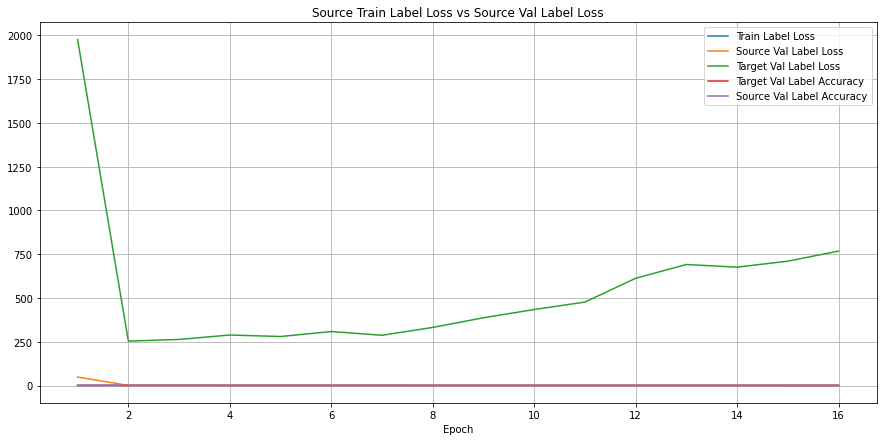

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

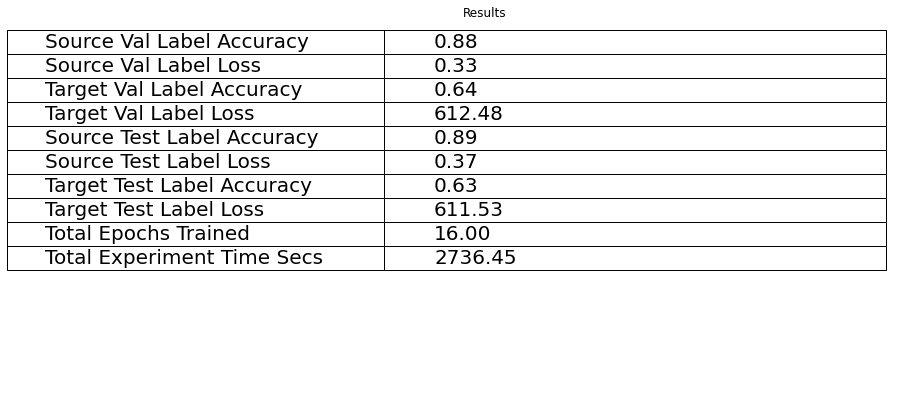

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

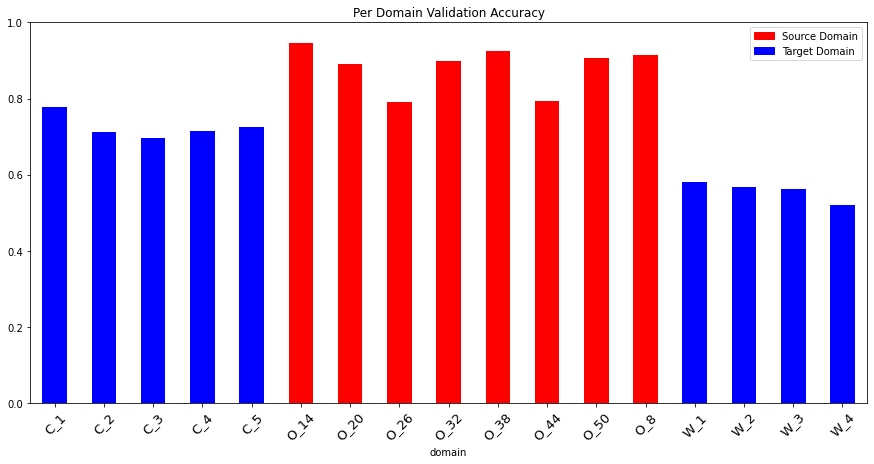

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8865234375 Target Test Label Accuracy: 0.6338877688172043
Source Val Label Accuracy: 0.8833984375 Target Val Label Accuracy: 0.6387877747252747


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3Av2:oracle.run1.framed -> cores+wisig", "parameters": {"experiment_name": "tl_3Av2:oracle.run1.framed -> cores+wisig", "device": "cuda", "lr": 0.0001, "x_shape": [2, 200], "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_